# Importing Data

This was the only way I could get the data onto google colab that I found online from https://colab.research.google.com/github/jsalbert/sound_classification_ml_production/blob/main/notebooks/UrbanSound8k_machine_learning.ipynb#scrollTo=sefSvCUtzKfx

In [ ]:
!pip install pandas
!pip install setuptools
!pip install numpy
!pip install sklearn
!pip install librosa
!pip install plotly
!pip install matplotlib
!pip install pillow
!pip install keras
!pip install audioread
!pip install torch
!pip install torchaudio
!pip install torchvision

In [2]:
import os
import time
import librosa
import zipfile
import numpy as np
import pandas as pd
import librosa.display
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from PIL import Image
import wave

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D
import joblib

In [ ]:
# Unzip dataset
!wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz -O urban8k.tgz
!tar -xzf urban8k.tgz
!rm urban8k.tgz

In [5]:
csv_path = "/content/UrbanSound8K/metadata/UrbanSound8K.csv"
metadata = pd.read_csv(csv_path)

In [6]:
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [ ]:
unique_values= metadata["class"].unique()
print(unique_values)

['dog_bark' 'children_playing' 'car_horn' 'air_conditioner' 'street_music'
 'gun_shot' 'siren' 'engine_idling' 'jackhammer' 'drilling']


#Preprocessing

Loading the audio files

In [7]:
def get_file_path(row):
    audio_directory = '/content/UrbanSound8K/audio'
    subfolder = "fold" + str(row['fold'])
    file_path = os.path.join(audio_directory, subfolder, row['slice_file_name'])
    return file_path

metadata['file_path'] = metadata.apply(get_file_path, axis=1)
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class,file_path
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,/content/UrbanSound8K/audio/fold5/100032-3-0-0...
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,/content/UrbanSound8K/audio/fold5/100263-2-0-1...
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,/content/UrbanSound8K/audio/fold5/100263-2-0-1...
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,/content/UrbanSound8K/audio/fold5/100263-2-0-1...
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,/content/UrbanSound8K/audio/fold5/100263-2-0-1...


In [ ]:
def get_sampling_rate(file_path):
    try:
        with wave.open(file_path, 'rb') as audio_file:
            sampling_rate = audio_file.getframerate()
        return sampling_rate
    except wave.Error as e:
        print(f"Error reading file {file_path}: {e}")
        return None

metadata['sampling_rate'] = metadata['file_path'].apply(lambda x: get_sampling_rate(x))

metadata.head()
# Example usage:
# file_path = '/content/UrbanSound8K/audio/fold1/101415-3-0-2.wav'
# sampling_rate = get_sampling_rate(file_path)
# print(f"Sampling rate: {sampling_rate} Hz")

In [ ]:
null_values = metadata["sampling_rate"].isnull().sum()
print("Number of null values in sampling_rate column:", null_values)

Number of null values in sampling_rate column: 0


In [ ]:
# Dropping null values to test if the data fits into the model
metadata.dropna(subset=['sampling_rate'], inplace=True)

Mel-Frequency Cepstral Coefficients (MFCCs): Instead of just taking the mean of MFCCs, you can also consider other statistics such as minimum, maximum, standard deviation, skewness, kurtosis, etc., to capture more information about the distribution of MFCCs over time.

Other Spectral Features: Apart from MFCCs, you can extract other spectral features such as Spectral Centroid, Spectral Contrast, Spectral Bandwidth, Spectral Rolloff, Chroma feature, Zero-Crossing Rate, etc. Each of these features provides different information about the audio signal.

Temporal Features: You can extract features related to the temporal characteristics of the audio signal, such as Root Mean Square (RMS) energy, Temporal Centroid, Temporal Flux, etc.

Statistical Features: In addition to the mean, consider extracting other statistical features such as variance, skewness, kurtosis, percentile values, etc., to capture the distributional properties of the audio features.

In [ ]:
audioData = []
srate = []
for index, row in metadata.iterrows():
  filename = row['file_path']
  data, sampleRate = librosa.load(filename)
  audioData.append(data)
  srate.append(sampleRate)

In [ ]:
# Faster Code move all functions over to this style
# MFCCS FEATURE
def extract_mfcc_scaled(file_path):
    # Load audio file with the provided sampling rate
    x, sample_rate = librosa.load(file_path)

    # Extract features
    mfcc =librosa.feature.mfcc(y=x, sr=sample_rate)
    mfccScaled = np.mean(mfcc.T, axis=0)
    return mfccScaled

def extract_mfcc(file_path):
    # Load audio file with the provided sampling rate
    x, sample_rate = librosa.load(file_path)

    # Extract features
    mfcc =librosa.feature.mfcc(y=x, sr=sample_rate, n_mfcc=50)
    return mfcc

# CHROMA
def extract_chroma(file_path):
    # Load audio file with the provided sampling rate
    x, sample_rate = librosa.load(file_path)
    # Extract features
    chroma = librosa.feature.chroma_stft(y=x, sr=sample_rate)
    return chroma

# SPECTRAL
def extract_spectral(file_path):
    # Load audio file with the provided sampling rate
    x, sample_rate = librosa.load(file_path)

    # Extract features
    spectral_contrast = librosa.feature.spectral_contrast(y=x, sr=sample_rate)
    return spectral_contrast

def extract_tonnetz(file_path):
  x, sample_rate = librosa.load(file_path)
  tonnetz = np.array(librosa.feature.tonnetz(y=x, sr=sample_rate))
  return tonnetz

def extract_melspectrogram(file_path):
  x, sample_rate = librosa.load(file_path)
  melspectrogram = np.array(librosa.feature.melspectrogram(y=x, sr=sample_rate))
  return melspectrogram

# metadata['mfccScaled'] = metadata.apply(lambda row: extract_mfcc_scaled(row['file_path']), axis=1)
metadata['mfcc'] = metadata.apply(lambda row: extract_mfcc(row['file_path']), axis=1)
metadata['chroma'] = metadata.apply(lambda row: extract_chroma(row['file_path']), axis=1)
metadata['spectral'] = metadata.apply(lambda row: extract_spectral(row['file_path']), axis=1)
metadata['tonnetz'] = metadata.apply(lambda row: extract_tonnetz(row['file_path']), axis=1)
metadata['melspectrogram'] = metadata.apply(lambda row: extract_melspectrogram(row['file_path']), axis=1)
metadata.head()

In [ ]:
metadata['mfccScaled'][0]

array([-211.93698   ,   62.58121   , -122.813156  ,  -60.745293  ,
        -13.893755  ,  -29.789837  ,   -3.978872  ,   11.682741  ,
         12.963834  ,    8.336421  ,   -6.529816  ,   -2.996103  ,
        -12.887945  ,    5.8859353 ,   -2.475222  ,   -4.408309  ,
        -15.014474  ,   -0.94399357,   -2.5799088 ,    6.0983005 ],
      dtype=float32)

In [9]:
import time
start_time = time.time()
# lets hope this doesnt stop running
metadata['mfcc_min'] = metadata['mfcc'].apply(np.min)
metadata['mfcc_mean'] = metadata['mfcc'].apply(np.mean)
metadata['mfcc_max'] = metadata['mfcc'].apply(np.max)
metadata['mfcc_median'] = metadata['mfcc'].apply(np.median)
metadata['mfcc_std'] = metadata['mfcc'].apply(np.std)
metadata['mfcc_var'] = metadata['mfcc'].apply(np.var)

metadata['chroma_min'] = metadata['chroma'].apply(np.min)
metadata['chroma_mean'] = metadata['chroma'].apply(np.mean)
metadata['chroma_max'] = metadata['chroma'].apply(np.max)
metadata['chroma_median'] = metadata['chroma'].apply(np.median)
metadata['chroma_std'] = metadata['chroma'].apply(np.std)
metadata['chroma_var'] = metadata['chroma'].apply(np.var)

metadata['spectral_min'] = metadata['spectral'].apply(np.min)
metadata['spectral_mean'] = metadata['spectral'].apply(np.mean)
metadata['spectral_max'] = metadata['spectral'].apply(np.max)
metadata['spectral_median'] = metadata['spectral'].apply(np.median)
metadata['spectral_std'] = metadata['spectral'].apply(np.std)
metadata['spectral_var'] = metadata['spectral'].apply(np.var)

metadata['tonnetz_min'] = metadata['tonnetz'].apply(np.min)
metadata['tonnetz_mean'] = metadata['tonnetz'].apply(np.mean)
metadata['tonnetz_max'] = metadata['tonnetz'].apply(np.max)
metadata['tonnetz_median'] = metadata['tonnetz'].apply(np.median)
metadata['tonnetz_std'] = metadata['tonnetz'].apply(np.std)
metadata['tonnetz_var'] = metadata['tonnetz'].apply(np.var)

metadata['melspectrogram_min'] = metadata['melspectrogram'].apply(np.min)
metadata['melspectrogram_mean'] = metadata['melspectrogram'].apply(np.mean)
metadata['melspectrogram_max'] = metadata['melspectrogram'].apply(np.max)
metadata['melspectrogram_median'] = metadata['melspectrogram'].apply(np.median)
metadata['melspectrogram_std'] = metadata['melspectrogram'].apply(np.std)
metadata['melspectrogram_var'] = metadata['melspectrogram'].apply(np.var)

end_time = time.time()

elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds")

metadata.head()

Elapsed time: 9.117979049682617 seconds


,slice_file_name,fsID,start,end,salience,fold,classID,class,file_path,mfcc,...,tonnetz_max,tonnetz_median,tonnetz_std,tonnetz_var,melspectrogram_min,melspectrogram_mean,melspectrogram_max,melspectrogram_median,melspectrogram_std,melspectrogram_var
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,/content/UrbanSound8K/audio/fold5/100032-3-0-0...,"[[-332.0388, -169.58775, -90.246826, -56.92346...",...,0.217819,-0.013603,0.074947,0.005617,6.210418e-08,4.515515,288.530853,0.010078,20.441442,417.852600
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,/content/UrbanSound8K/audio/fold5/100263-2-0-1...,"[[-486.0561, -447.30463, -441.84772, -436.2217...",...,0.099848,-0.010990,0.035970,0.001294,8.001759e-10,0.002774,0.270998,0.000331,0.010701,0.000115
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,/content/UrbanSound8K/audio/fold5/100263-2-0-1...,"[[-492.76328, -465.86954, -473.96152, -480.512...",...,0.128016,-0.000262,0.044803,0.002007,7.679792e-10,0.001810,0.447264,0.000159,0.008701,0.000076
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,/content/UrbanSound8K/audio/fold5/100263-2-0-1...,"[[-441.2638, -405.2567, -401.20792, -400.8395,...",...,0.144122,0.007380,0.048015,0.002305,1.713496e-08,0.004552,0.997788,0.000300,0.025150,0.000633
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,/content/UrbanSound8K/audio/fold5/100263-2-0-1...,"[[-467.48068, -431.21393, -435.46893, -434.359...",...,0.173125,0.026670,0.043504,0.001893,1.286259e-09,0.001949,0.234845,0.000217,0.008418,0.000071


# Models

### Random Forest Classifier

In [11]:
# CURRENT BEST TO WORK WITH

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

features = ['mfcc_mean', 'mfcc_min', 'mfcc_max', 'mfcc_median', 'mfcc_std', 'mfcc_var', 'chroma_mean', 'chroma_min', 'chroma_max', 'chroma_median', 'chroma_std', 'chroma_var', 'spectral_mean', 'spectral_min', 'spectral_max', 'spectral_median', 'spectral_std', 'spectral_var', 'tonnetz_mean', 'tonnetz_min', 'tonnetz_max', 'tonnetz_median', 'tonnetz_std', 'tonnetz_var', 'melspectrogram_mean', 'melspectrogram_min', 'melspectrogram_max', 'melspectrogram_median', 'melspectrogram_std', 'melspectrogram_var']
# Split data into train and test sets
X = metadata[features]
y = metadata['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=42)
rf_classifier.fit(X_train, y_train)

# Prediction on test data
y_pred_rf = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)

# joblib to help download model
# joblib.dump(rf_classifier, 'random_forest_model.pkl')


Random Forest Accuracy: 0.8620492272467086


In [ ]:
from google.colab import files
files.download('random_forest_model.pkl') # This is to download the model

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Random Forest Precision: 0.8650679131345038
Random Forest Recall: 0.8620492272467086
[0.91625616 0.65116279 0.83060109 0.79104478 0.89805825 0.95336788
 0.95833333 0.94230769 0.87272727 0.76086957]


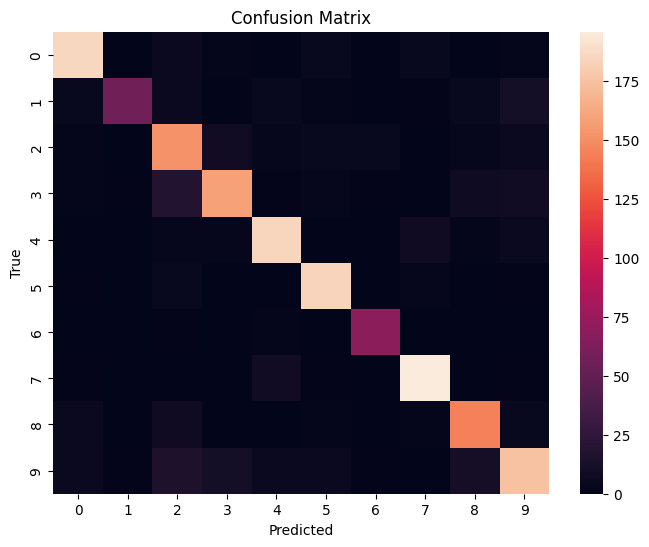

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')

print("Random Forest Precision:", precision_rf)
print("Random Forest Recall:", recall_rf)

from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred_rf)
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
print(class_accuracy)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### Convultional Neural Network (CNN)

In [ ]:
# Bad CNN use random forest classifier, works better with limited data
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.callbacks import EarlyStopping
# from keras.layers import Dense, Dropout

# features = ['mfcc_mean', 'mfcc_min', 'mfcc_max', 'mfcc_median', 'mfcc_std', 'mfcc_var', 'chroma_mean', 'chroma_min', 'chroma_max', 'chroma_median', 'chroma_std', 'chroma_var', 'spectral_mean', 'spectral_min', 'spectral_max', 'spectral_median', 'spectral_std', 'spectral_var', 'tonnetz_mean', 'tonnetz_min', 'tonnetz_max', 'tonnetz_median', 'tonnetz_std', 'tonnetz_var', 'melspectrogram_mean', 'melspectrogram_min', 'melspectrogram_max', 'melspectrogram_median', 'melspectrogram_std', 'melspectrogram_var']

# X = metadata[features]
# y = metadata['class']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# target_variable = 'classID'

# X = metadata[features].values
# y = metadata[target_variable].values

# # Define model
# num_classes = 10
# model = Sequential([
#     Dense(128, activation='relu', input_shape=(len(features),)),
#     Dropout(0.5),
#     Dense(256, activation='relu'),
#     Dense(128, activation='relu'),
#     Dense(64, activation='relu'),
#     Dense(32, activation='relu'),
#     Dense(num_classes, activation='softmax')  # Adjust num_classes based on your task
# ])

# # Compile model
# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',  # Adjust loss function based on your task
#               metrics=['accuracy'])

# early_stop = EarlyStopping(monitor='accuracy', patience=50)

# model.summary()

# # Train model
# model.fit(X, y, epochs=5000, batch_size=64, validation_split=0.05, callbacks=[early_stop])


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 128)               3968      
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 256)               33024     
                                                                 
 dense_17 (Dense)            (None, 128)               32896     
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dense_19 (Dense)            (None, 32)                2080      
                                                                 
 dense_20 (Dense)            (None, 10)               

### Recurrent Neural Network (RNN)

In [ ]:
# Dont use this model
# features = ['mfcc_mean', 'mfcc_min', 'mfcc_max', 'mfcc_median', 'mfcc_std', 'mfcc_var', 'chroma_mean', 'chroma_min', 'chroma_max', 'chroma_median', 'chroma_std', 'chroma_var', 'spectral_mean', 'spectral_min', 'spectral_max', 'spectral_median', 'spectral_std', 'spectral_var', 'tonnetz_mean', 'tonnetz_min', 'tonnetz_max', 'tonnetz_median', 'tonnetz_std', 'tonnetz_var', 'melspectrogram_mean', 'melspectrogram_min', 'melspectrogram_max', 'melspectrogram_median', 'melspectrogram_std', 'melspectrogram_var']

# X = metadata[features]
# y = metadata['class']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# history = model.fit(X_train, y_train, epochs=10, batch_size=32)

# test_loss, test_acc = model.evaluate(X_test, y_test)

# print('Test accuracy:', test_acc)

# import matplotlib.pyplot as plt

# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs = range(1, len(acc) + 1)

# plt.plot(epochs, acc, 'bo', label='Training acc')
# plt.plot(epochs, val_acc, 'b', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.legend()

# plt.figure()

# plt.plot(epochs, loss, 'bo', label='Training loss')
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
# plt.title('Training and validation loss')
# plt.legend()

# plt.show()


# Random useless code

In [ ]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt

csv_path = "/content/UrbanSound8K/metadata/UrbanSound8K.csv"
metadata = pd.read_csv(csv_path)
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


<ipython-input-38-8979fccbc9b4>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10,3))


KeyboardInterrupt: 

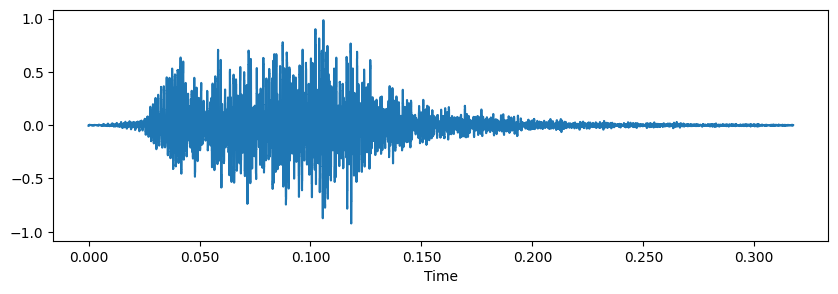

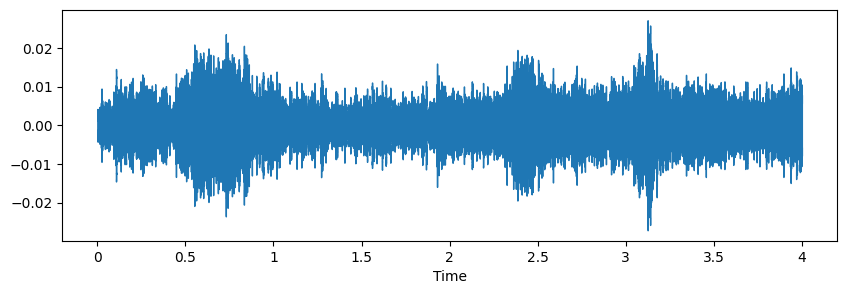

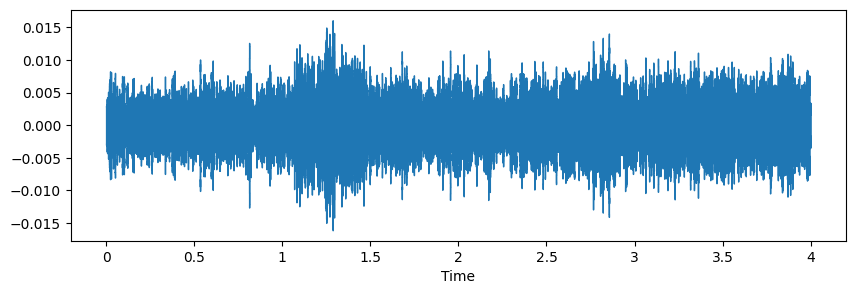

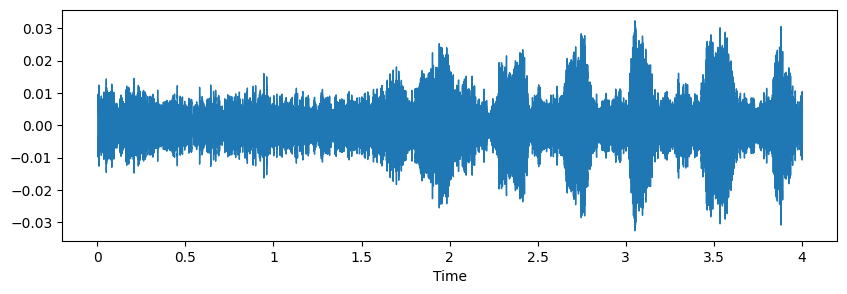

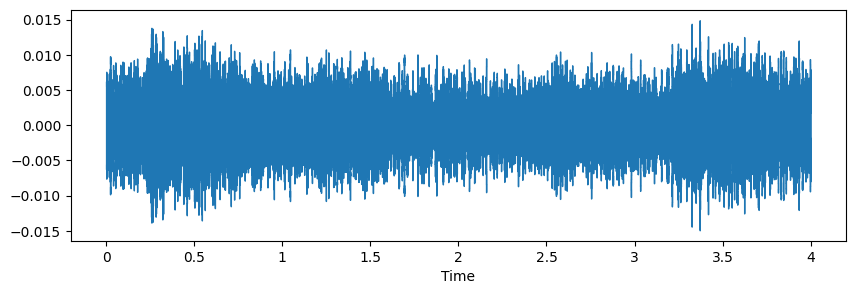

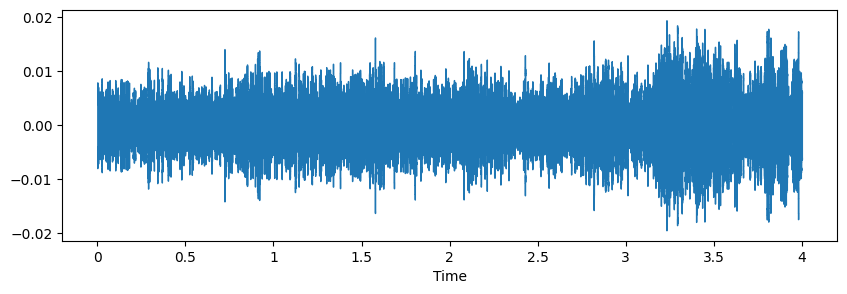

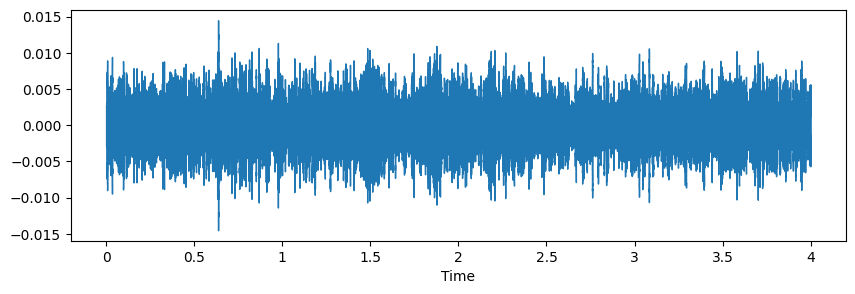

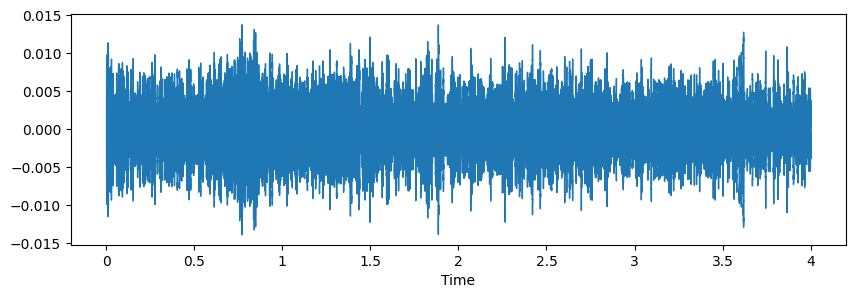

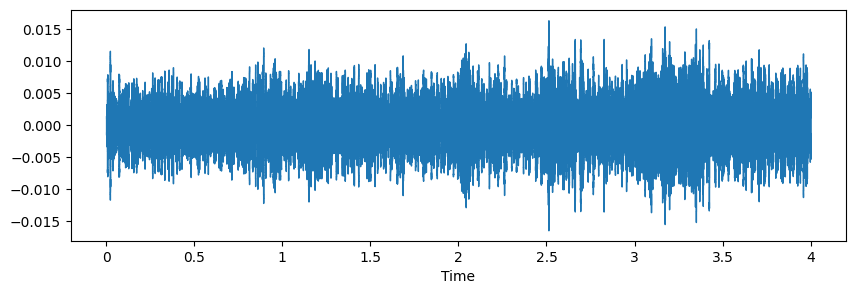

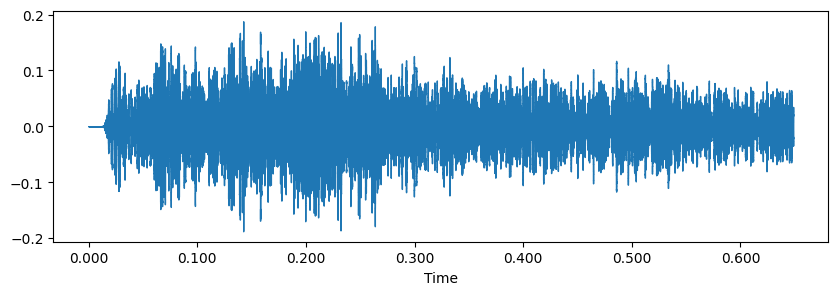

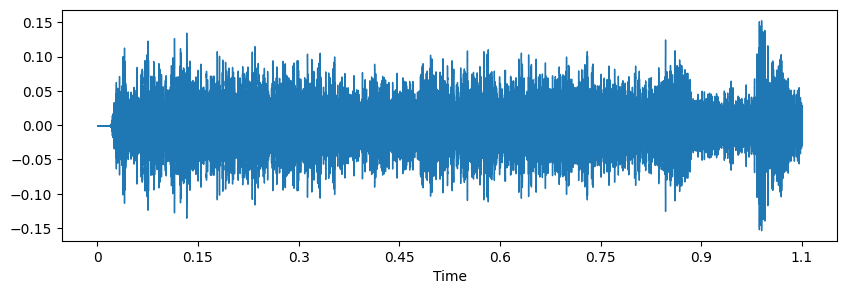

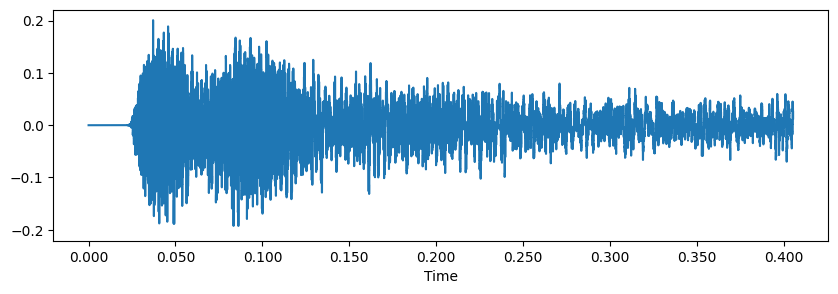

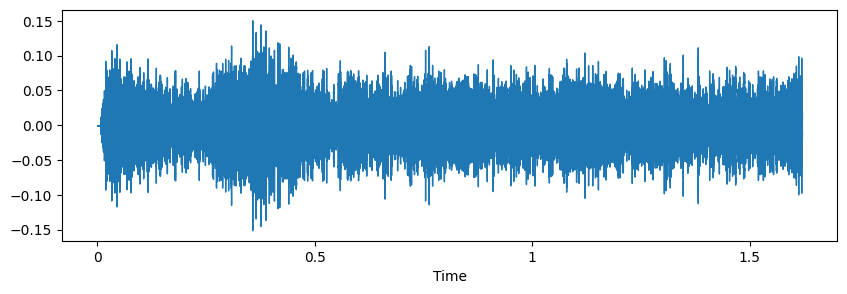

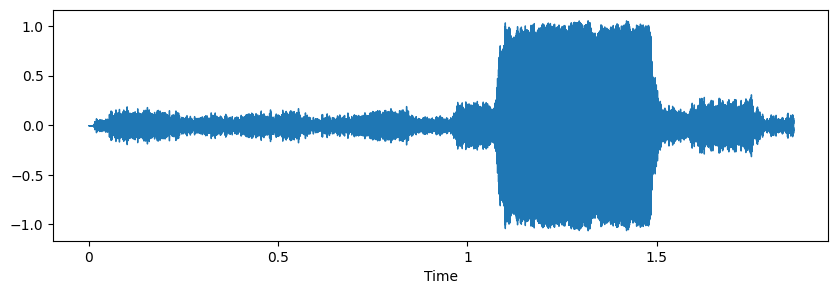

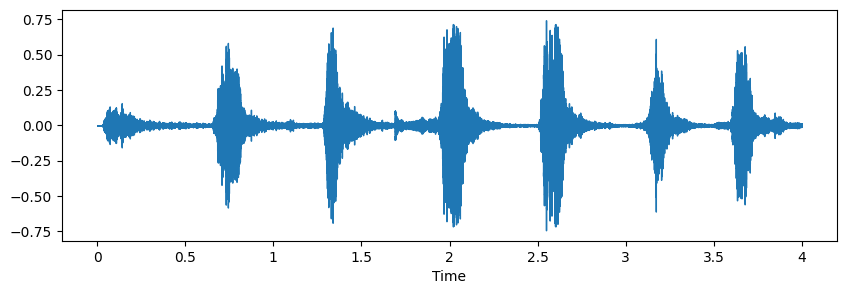

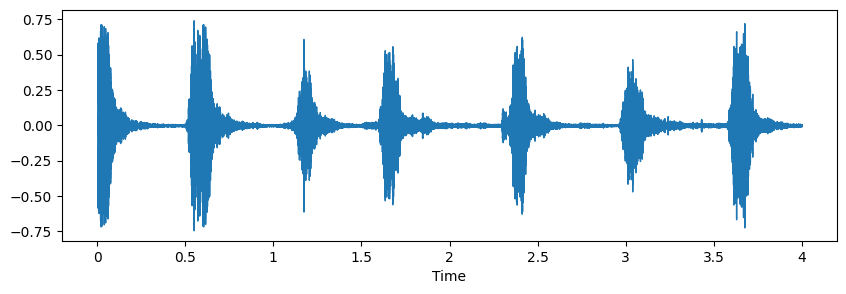

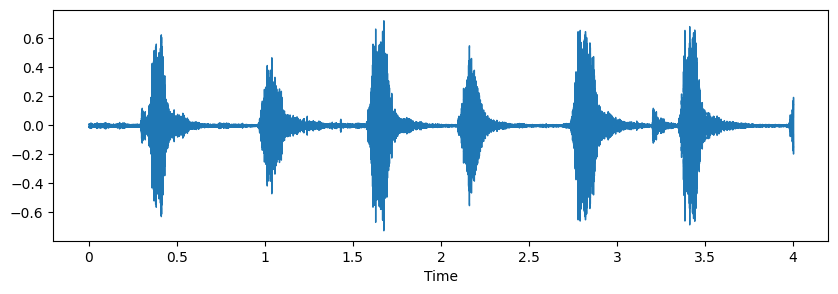

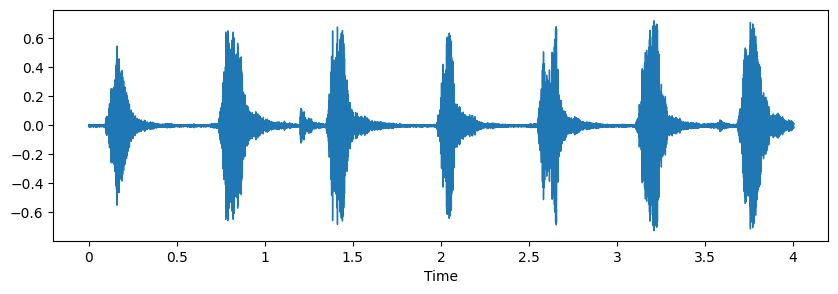

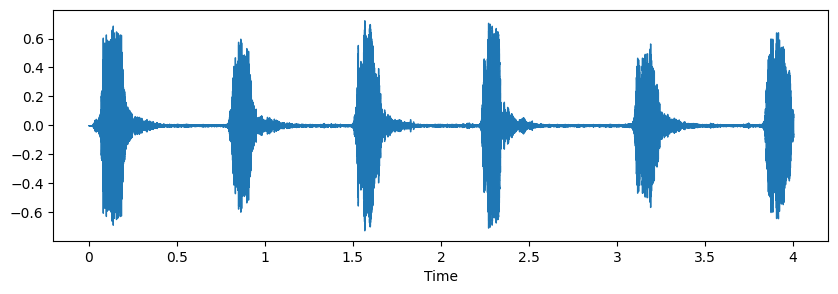

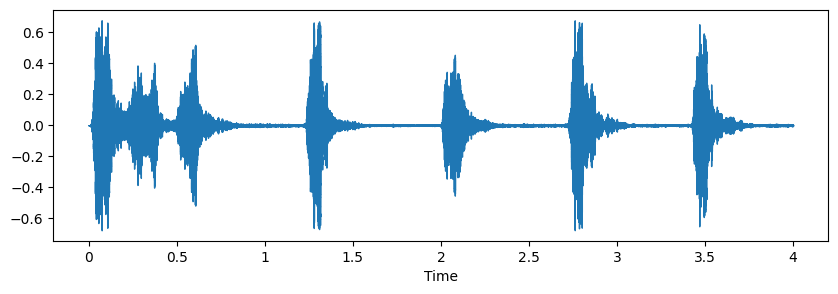

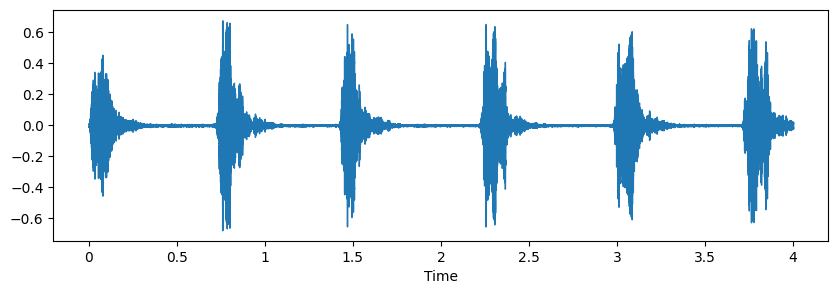

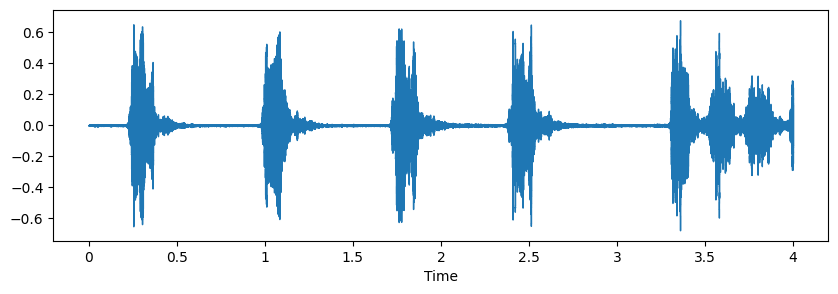

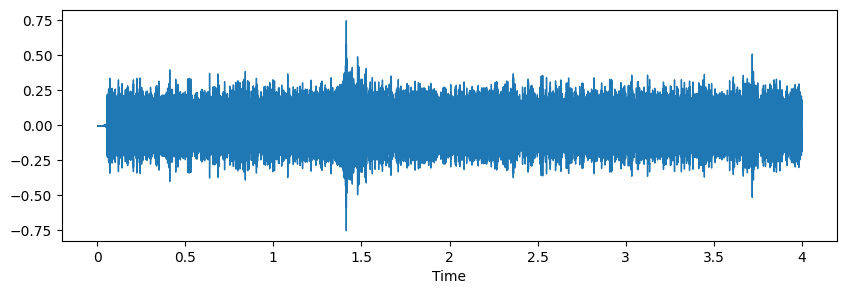

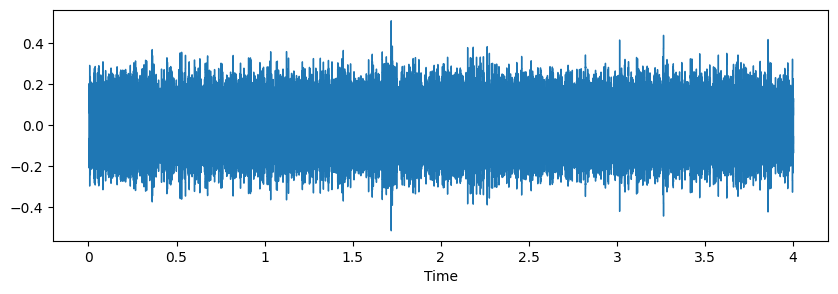

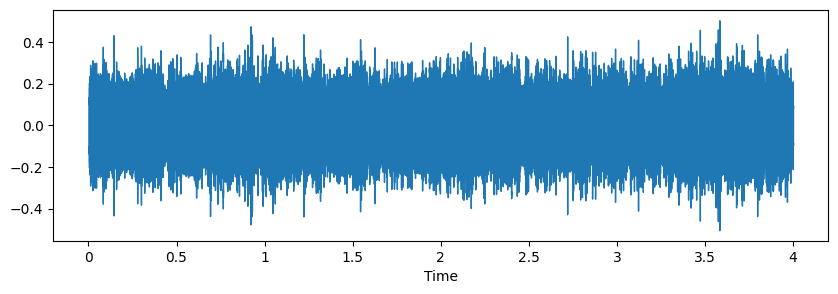

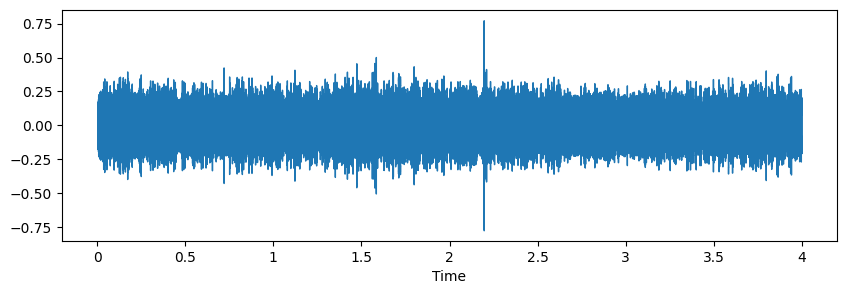

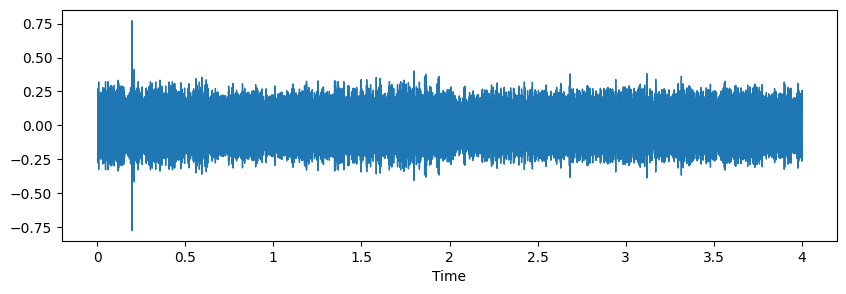

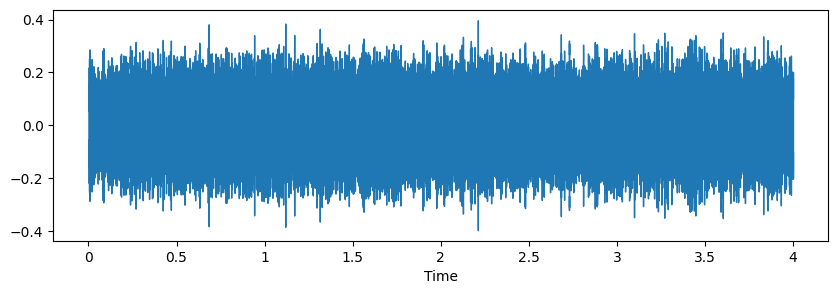

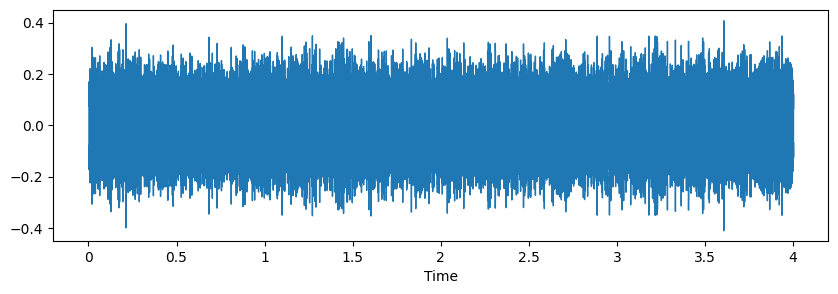

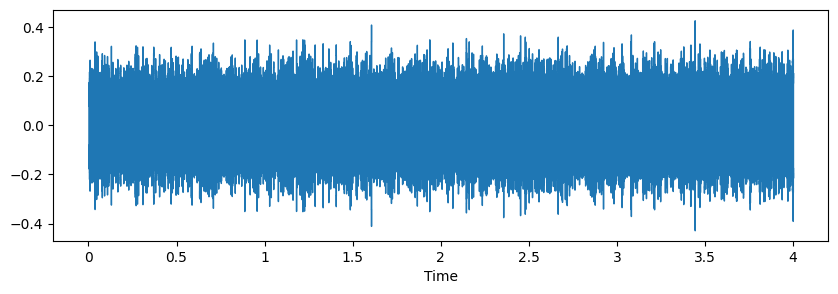

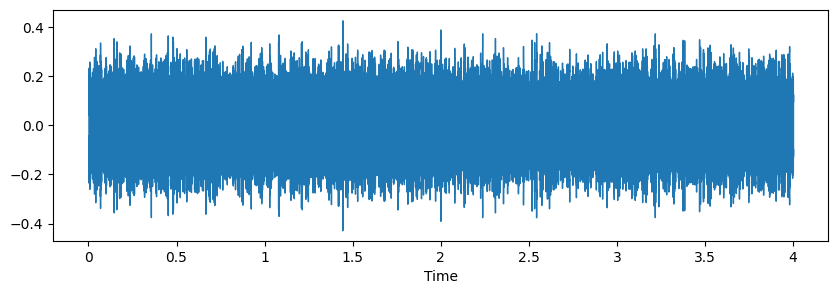

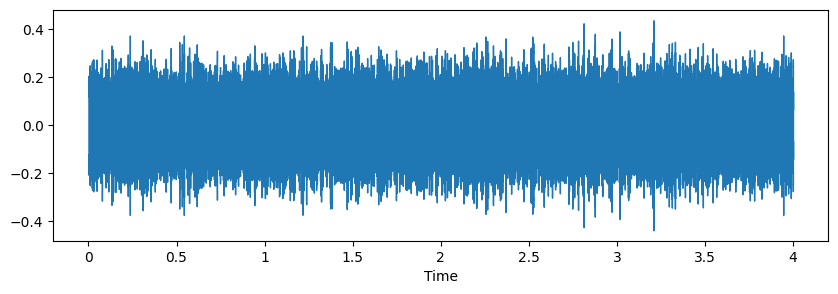

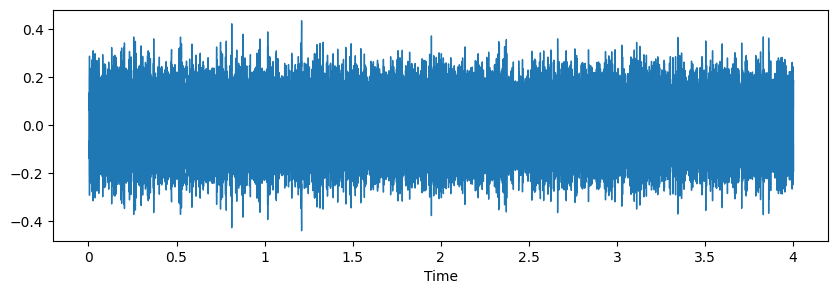

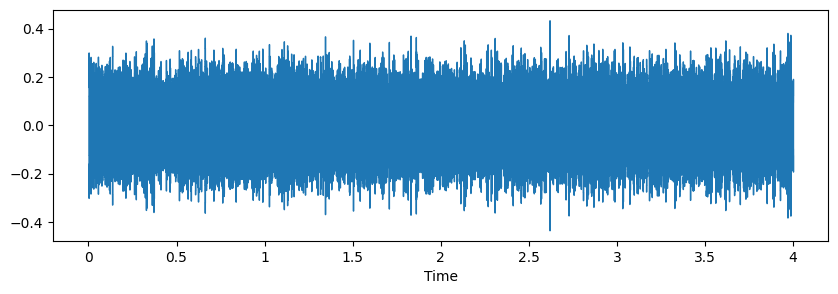

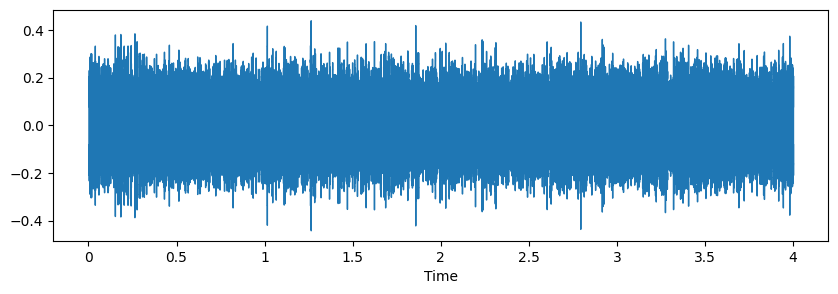

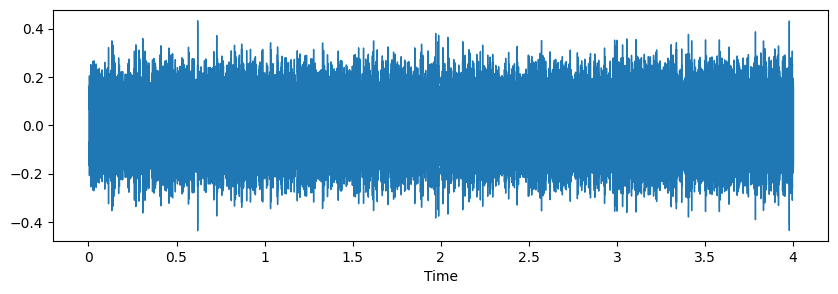

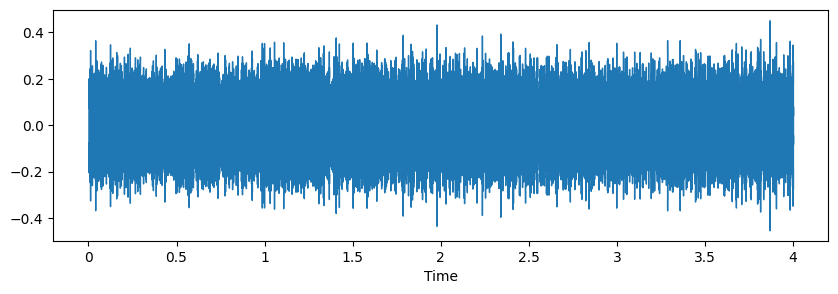

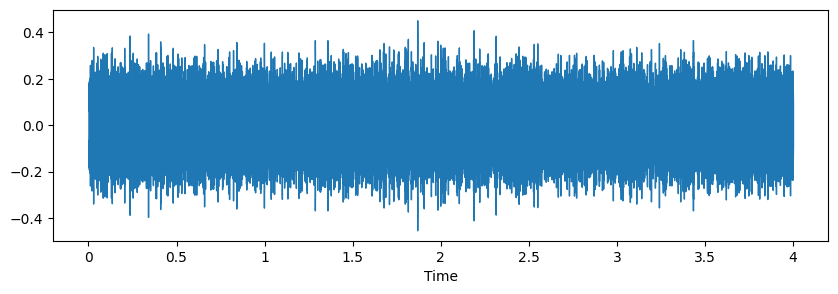

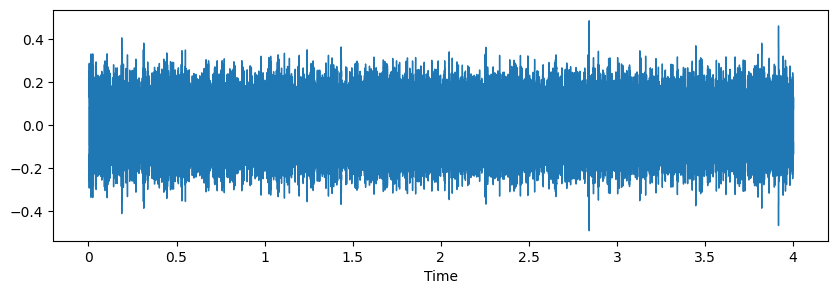

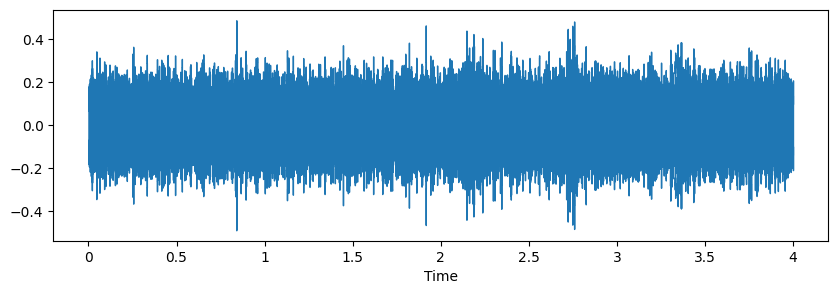

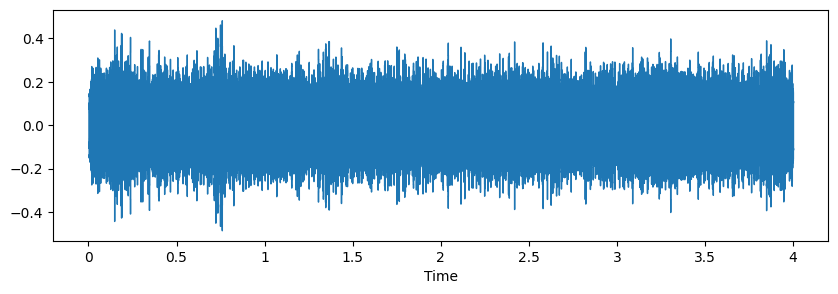

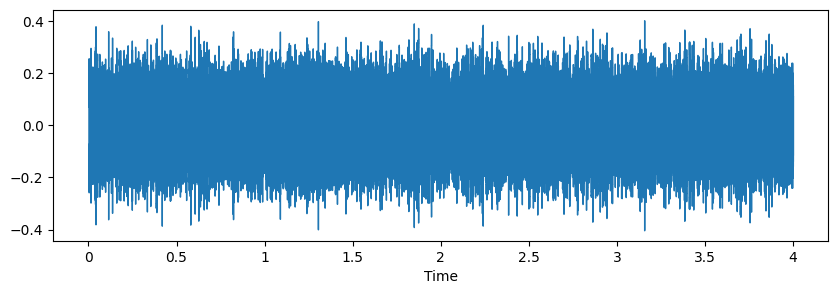

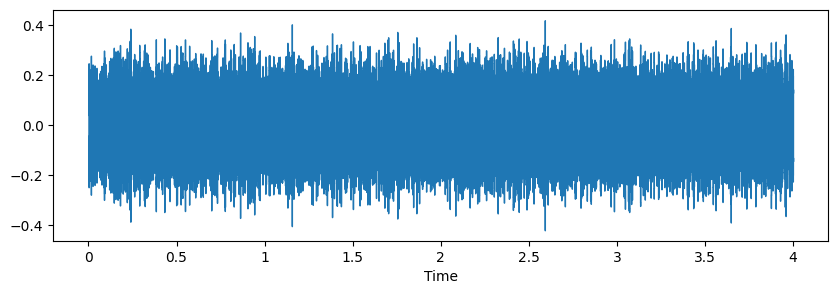

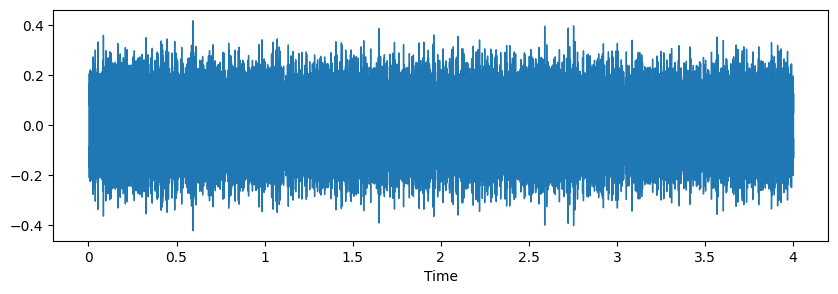

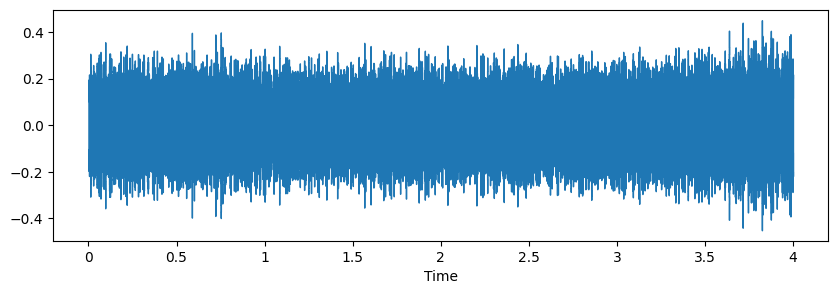

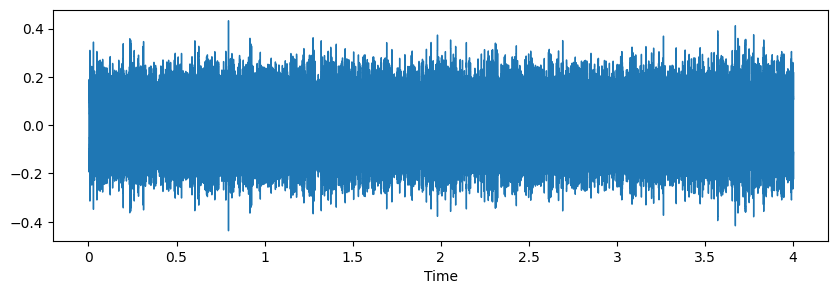

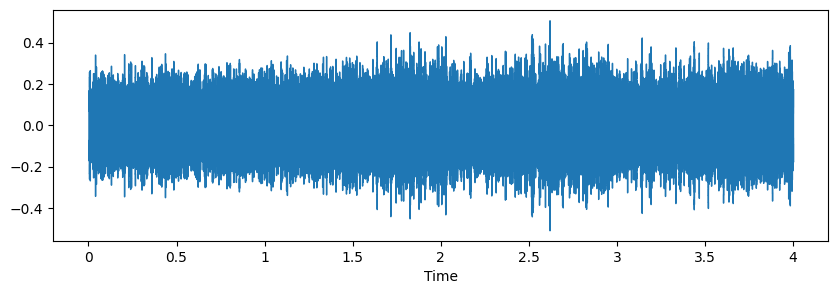

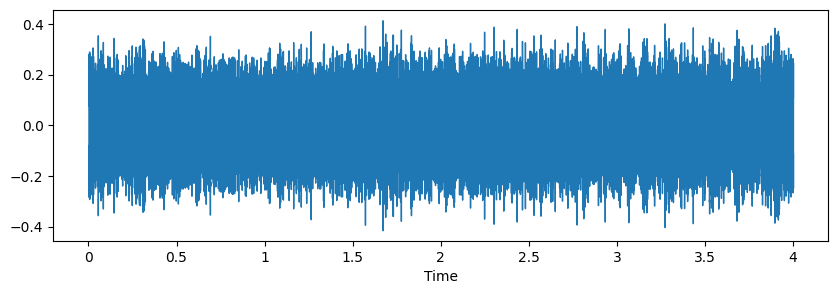

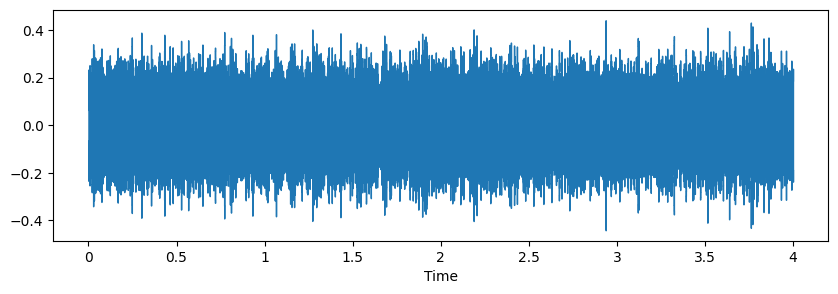

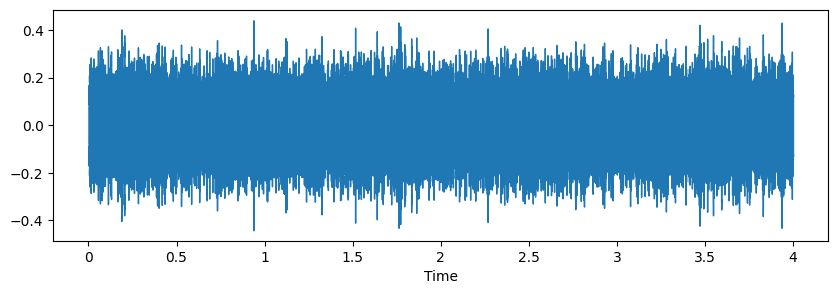

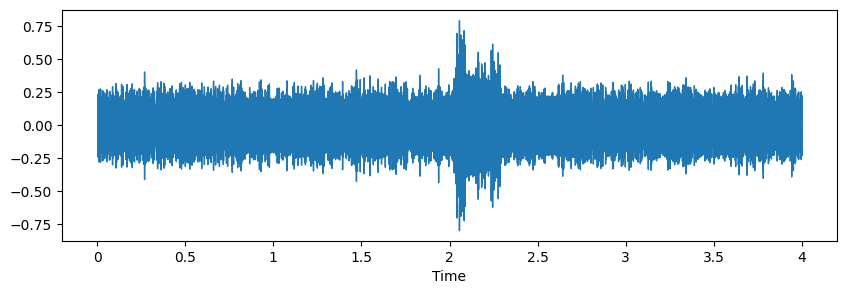

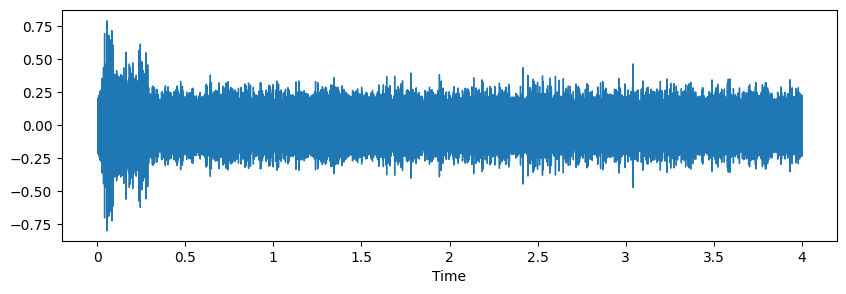

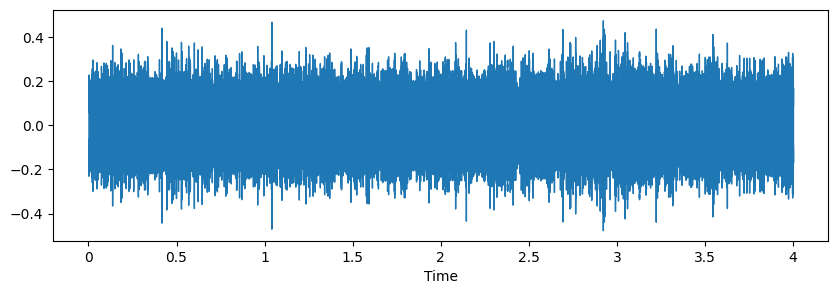

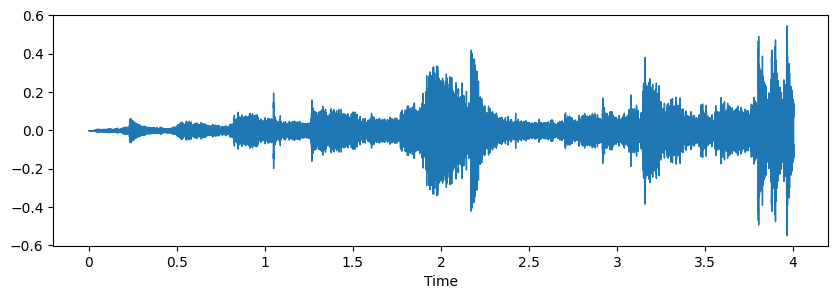

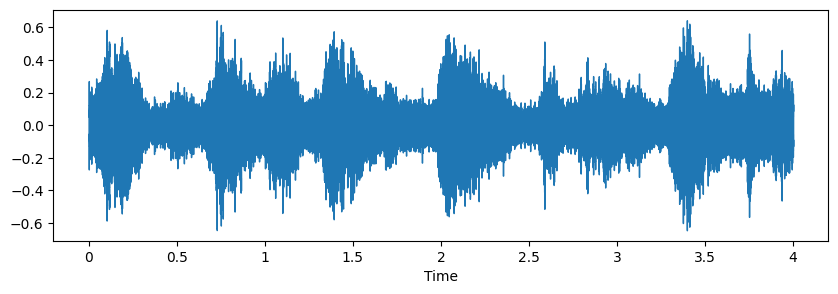

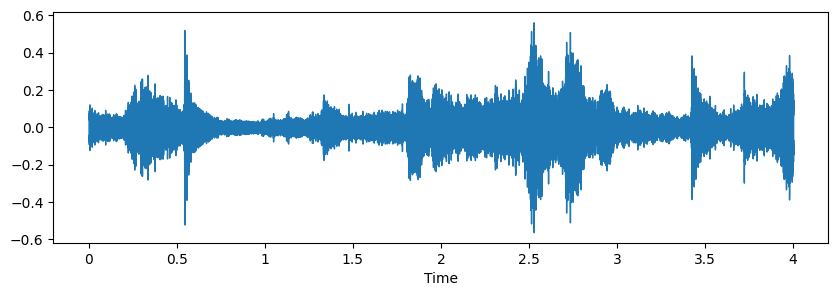

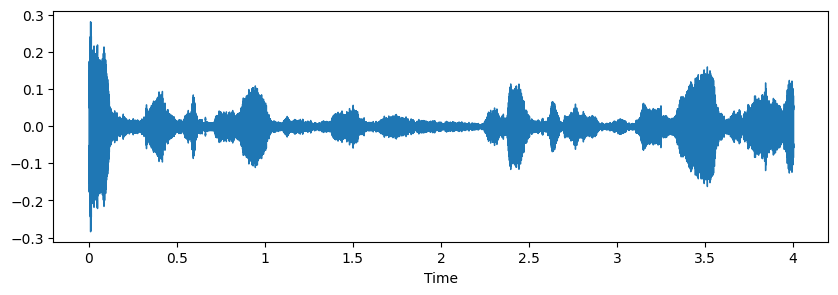

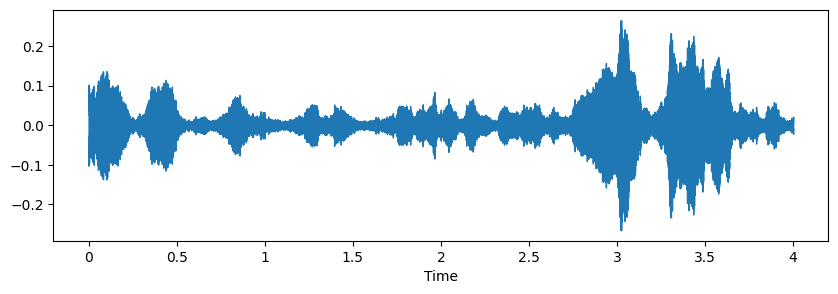

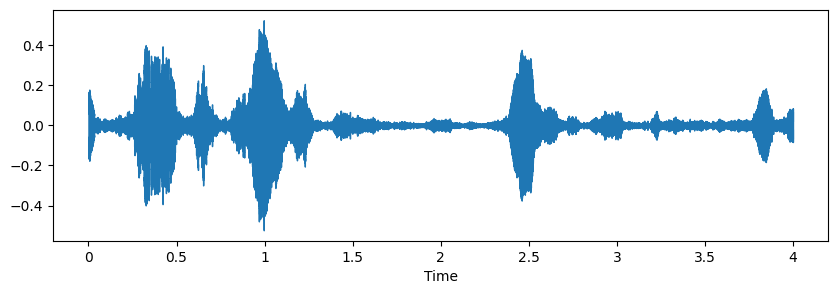

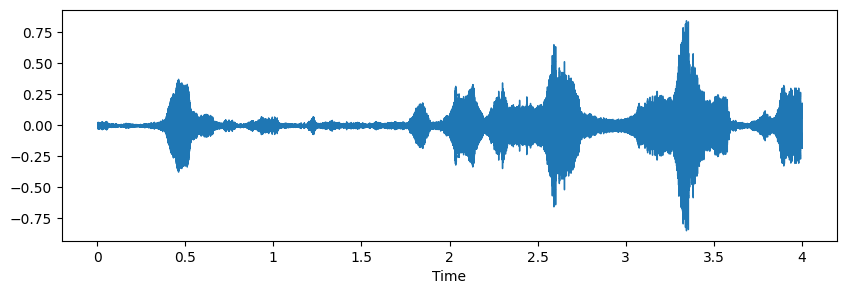

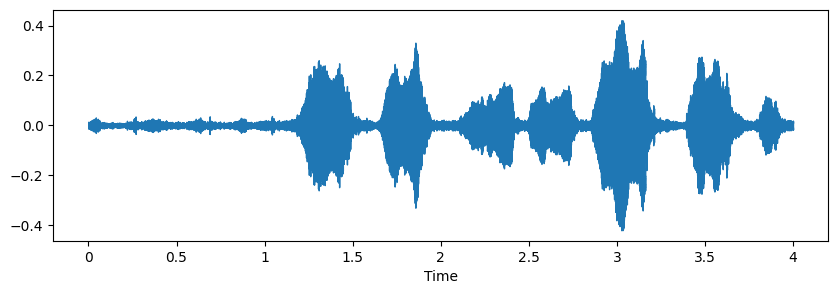

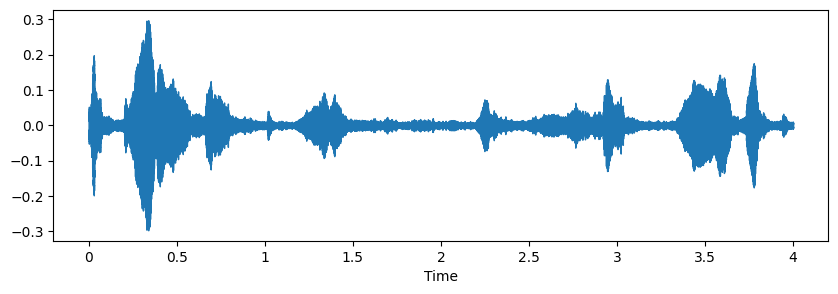

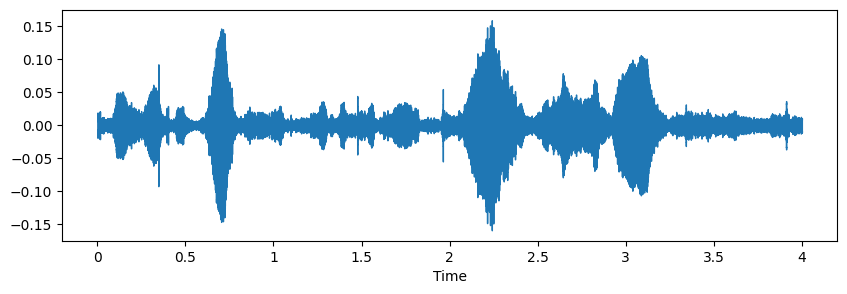

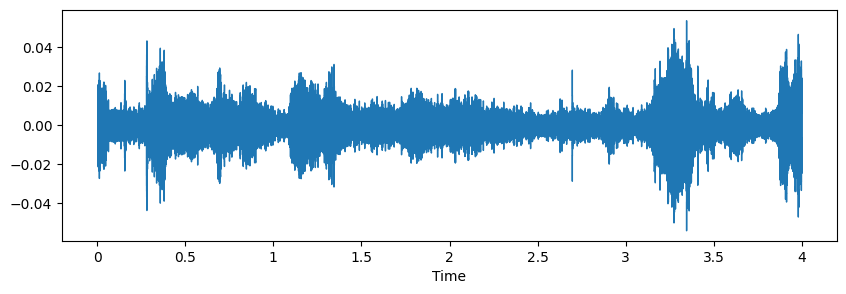

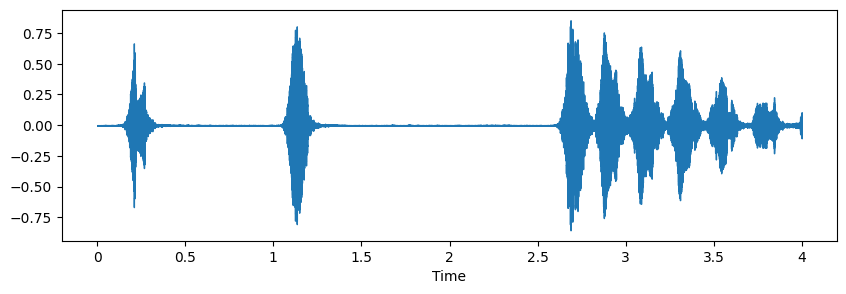

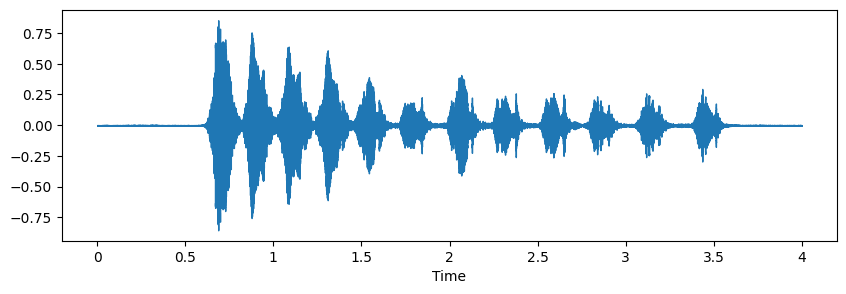

Error in callback <function flush_figures at 0x78703a218160> (for post_execute):


KeyboardInterrupt: 

In [ ]:
def get_file_path(row):
    audio_directory = '/content/UrbanSound8K/audio'
    subfolder = "fold" + str(row['fold'])
    file_path = os.path.join(audio_directory, subfolder, row['slice_file_name'])
    return file_path

metadata['file_path'] = metadata.apply(get_file_path, axis=1)
metadata.head()

audioData = []
srate = []
for index, row in metadata.iterrows():
  filename = row['file_path']
  data, sampleRate = librosa.load(filename)
  audioData.append(data)
  srate.append(sampleRate)
  plt.figure(figsize=(10,3))
  librosa.display.waveshow(data)

In [ ]:
print(srate)
# for a, s in zip(audioData, srate):
#   mfcc = librosa.feature.mfcc(y=a, sr=s)
#   mfccScaled = np.mean(mfcc.T, axis=0)
#   print(mfccScaled) plt.plot(mfccScaled, 'g')
#   plt.show()

[22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050